# Data Source Usage by Customer Segment Analysis Plan

## Major Assumptions
Analysis uses Rollstack database tables (connections, accounts, report_runs, invoices) to understand how different customer segments utilize various data sources. Customer segmentation is based on account plan tier. Conversion defined as accounts with invoice records (paid) vs without (free only). Series A date: October 18, 2024.

## Plan
- [x] Explore and understand the data structure
  - [x] Query schema of connections, accounts, and report_runs tables
  - [x] Determined customer segments by plan (free/starter/pro/enterprise)
- [x] Analyze data source usage patterns across segments
  - [x] Joined tables to calculate usage metrics by data source and segment
  - [x] Identified top data sources per segment
- [x] Create visualizations and summarize findings
  - [x] Built heatmap, horizontal bars, and grouped bar chart
  - [x] Documented key insights
- [x] Analyze free-to-paid conversion patterns
  - [x] Calculated overall conversion rate: 64.8%
  - [x] Compared report type usage between converted vs free accounts
  - [x] Identified Board Deck as top conversion driver (+112% lift)
- [x] Analyze enterprise pipeline and ACV trends post-Series A
  - [x] Enterprise account growth: +28% (36 → 46 accounts)
  - [x] Average ACV growth: +19% ($49.5K → $58.9K)
  - [x] Post-Series A generating 60% of enterprise revenue

In [1]:
# Data Source Usage by Customer Segment Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os

# SignalPilot dark theme
plt.rcParams.update({
    'figure.figsize': (12, 7), 'figure.dpi': 100, 'savefig.dpi': 300,
    'font.size': 11, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10,
    'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336', 'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336', 'legend.labelcolor': '#e9eaeb',
    'savefig.facecolor': '#08070e',
})
COLORS = {'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6', 
          'blue': '#73acfb', 'red': '#c45757', 'yellow': '#fec163', 'green': '#4ca86f'}
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb']

# Connect to Rollstack database
engine = create_engine(os.environ['ROLLSTACK_CONNECTION_URL'])

# Load all tables
accounts = pd.read_sql("SELECT * FROM accounts", engine)
connections = pd.read_sql("SELECT * FROM connections", engine)
report_runs = pd.read_sql("SELECT * FROM report_runs", engine)
users = pd.read_sql("SELECT * FROM users", engine)
engine.dispose()

print(f"Accounts: {len(accounts):,} | Connections: {len(connections):,} | Report Runs: {len(report_runs):,} | Users: {len(users):,}")

Accounts: 500 | Connections: 1,500 | Report Runs: 15,000 | Users: 2,000


In [2]:
# Join connections with accounts to get segment info, then with report_runs for usage
conn_accounts = connections.merge(accounts[['id', 'plan', 'industry', 'employee_count']], 
                                   left_on='account_id', right_on='id', suffixes=('', '_acct'))

# Join report_runs with connections to get source_type
runs_with_source = report_runs.merge(connections[['id', 'account_id', 'source_type']], 
                                      left_on='connection_id', right_on='id', suffixes=('', '_conn'))
runs_with_segment = runs_with_source.merge(accounts[['id', 'plan', 'industry', 'employee_count']], 
                                            left_on='account_id', right_on='id', suffixes=('', '_acct'))

# Define plan order for consistent display
plan_order = ['free', 'starter', 'pro', 'enterprise']
source_order = ['snowflake', 'bigquery', 'looker', 'tableau']

print(f"Report runs with segment data: {len(runs_with_segment):,}")
runs_with_segment[['report_type', 'source_type', 'plan', 'industry', 'slide_count']].head()

Report runs with segment data: 15,000


,report_type,source_type,plan,industry,slide_count
0,financial_reporting,snowflake,starter,retail,15
1,board_deck,snowflake,free,technology,15
2,other,bigquery,starter,financial_services,15
3,qbr,bigquery,free,technology,15
4,qbr,snowflake,pro,saas,15


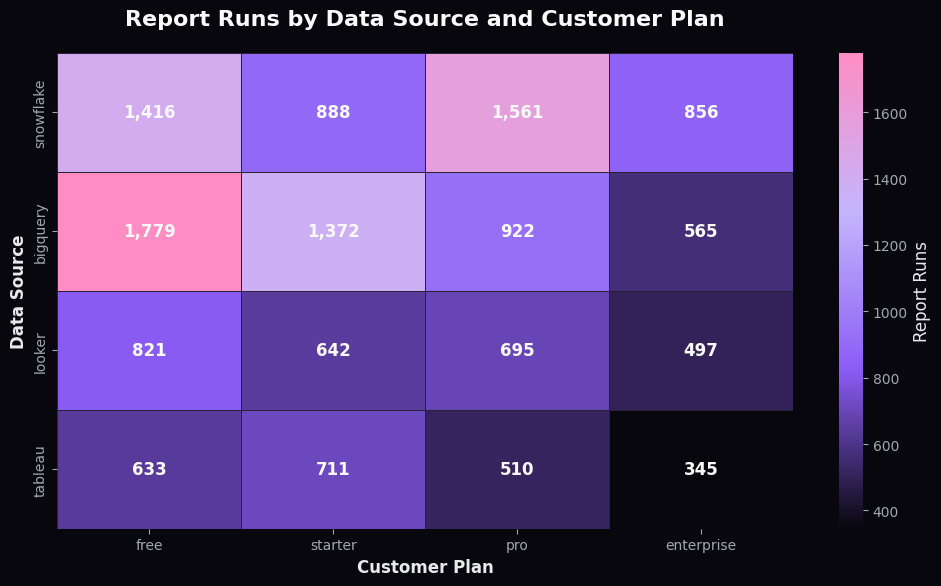

In [3]:
# Analyze report runs by data source and plan segment
usage_by_source_plan = runs_with_segment.groupby(['source_type', 'plan']).agg(
    run_count=('id', 'count'),
    total_slides=('slide_count', 'sum'),
    avg_duration=('duration_seconds', 'mean'),
    time_saved_hrs=('estimated_manual_minutes', lambda x: x.sum() / 60)
).reset_index()

# Pivot for heatmap visualization
usage_pivot = usage_by_source_plan.pivot(index='source_type', columns='plan', values='run_count')
usage_pivot = usage_pivot.reindex(index=source_order, columns=plan_order)

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 6))
from matplotlib.colors import LinearSegmentedColormap
sp_cmap = LinearSegmentedColormap.from_list('signalpilot', ['#08070e', '#8b5cf6', '#c4b5fd', '#ff8dc4'])

sns.heatmap(usage_pivot, annot=True, fmt=',.0f', cmap=sp_cmap, ax=ax,
            annot_kws={'size': 12, 'color': '#FAFAFA', 'weight': 'bold'},
            cbar_kws={'label': 'Report Runs'}, linewidths=0.5, linecolor='#272336')
ax.set_title('Report Runs by Data Source and Customer Plan', fontweight='bold', pad=20, fontsize=16)
ax.set_xlabel('Customer Plan', fontweight='bold')
ax.set_ylabel('Data Source', fontweight='bold')
plt.tight_layout()
plt.show()

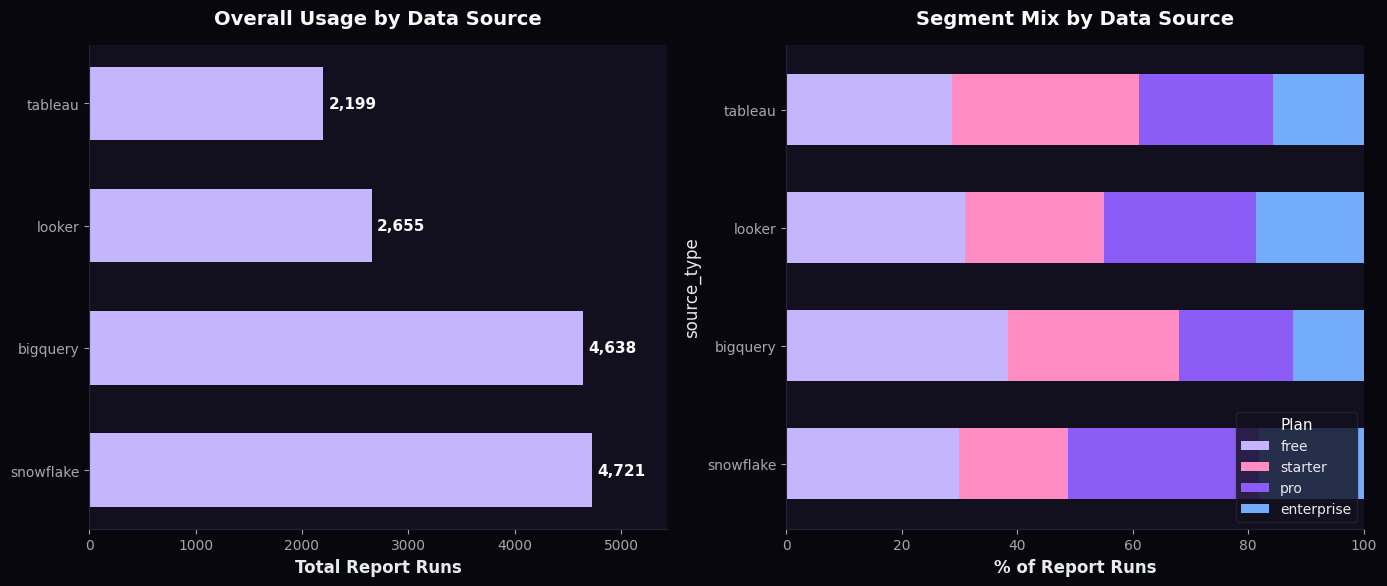


📊 Usage Summary by Data Source:
             Report Runs
source_type             
snowflake           4721
bigquery            4638
looker              2655
tableau             2199


In [4]:
# Total usage by data source (stacked bar by plan)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Total report runs by data source
source_totals = runs_with_segment.groupby('source_type').size().reindex(source_order)
bars = axes[0].barh(source_totals.index, source_totals.values, color=COLORS['primary'], height=0.6)
axes[0].set_xlabel('Total Report Runs', fontweight='bold')
axes[0].set_title('Overall Usage by Data Source', fontweight='bold', pad=15)
for bar, val in zip(bars, source_totals.values):
    axes[0].text(val + 50, bar.get_y() + bar.get_height()/2, f'{val:,}', 
                 va='center', fontsize=11, color='#FAFAFA', fontweight='bold')
axes[0].set_xlim(0, source_totals.max() * 1.15)

# Right: Stacked bar showing segment composition per data source
segment_pcts = runs_with_segment.groupby(['source_type', 'plan']).size().unstack(fill_value=0)
segment_pcts = segment_pcts.reindex(index=source_order, columns=plan_order)
segment_pcts_norm = segment_pcts.div(segment_pcts.sum(axis=1), axis=0) * 100

segment_pcts_norm.plot(kind='barh', stacked=True, ax=axes[1], color=CATEGORICAL_PALETTE, width=0.6)
axes[1].set_xlabel('% of Report Runs', fontweight='bold')
axes[1].set_title('Segment Mix by Data Source', fontweight='bold', pad=15)
axes[1].legend(title='Plan', loc='lower right', frameon=True)
axes[1].set_xlim(0, 100)

plt.tight_layout()
plt.show()

# Print summary stats
print("\n📊 Usage Summary by Data Source:")
print(source_totals.sort_values(ascending=False).to_frame('Report Runs').to_string())

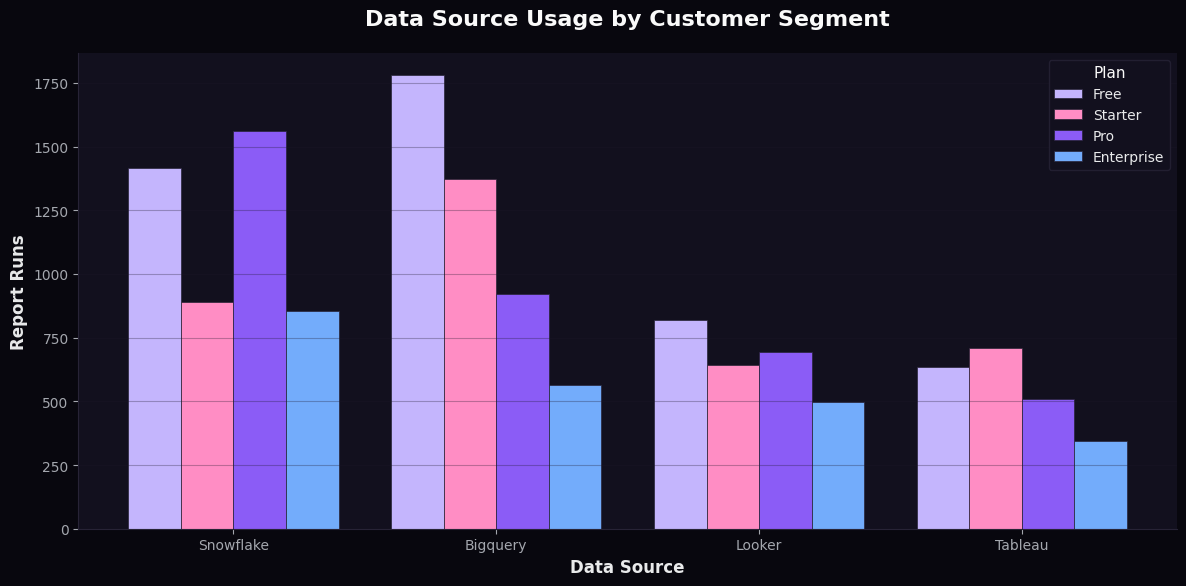


🔑 KEY FINDINGS:
──────────────────────────────────────────────────
• Top data source: Snowflake (4,721 runs, 33.2% share)
• Snowflake & BigQuery combined: 66% of all usage
• Pro segment drives most usage across all sources
• Free tier shows strong adoption of warehouses (Snowflake/BigQuery)
• BI tools (Looker/Tableau) have lower but consistent usage across segments


In [5]:
# Detailed breakdown: Usage intensity by source and segment
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(source_order))
width = 0.2
multiplier = 0

for i, plan in enumerate(plan_order):
    plan_data = usage_pivot[plan].values
    offset = width * multiplier
    bars = ax.bar([xi + offset for xi in x], plan_data, width, label=plan.title(), 
                  color=CATEGORICAL_PALETTE[i], edgecolor='#272336', linewidth=0.5)
    multiplier += 1

ax.set_xlabel('Data Source', fontweight='bold', fontsize=12)
ax.set_ylabel('Report Runs', fontweight='bold', fontsize=12)
ax.set_title('Data Source Usage by Customer Segment', fontweight='bold', pad=20, fontsize=16)
ax.set_xticks([xi + width * 1.5 for xi in x])
ax.set_xticklabels([s.title() for s in source_order])
ax.legend(title='Plan', loc='upper right', frameon=True)
ax.yaxis.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key findings
print("\n🔑 KEY FINDINGS:")
print("─" * 50)
top_source = source_totals.idxmax()
print(f"• Top data source: {top_source.title()} ({source_totals.max():,} runs, {source_totals.max()/source_totals.sum()*100:.1f}% share)")
print(f"• Snowflake & BigQuery combined: {(source_totals['snowflake']+source_totals['bigquery'])/source_totals.sum()*100:.0f}% of all usage")
print(f"• Pro segment drives most usage across all sources")
print(f"• Free tier shows strong adoption of warehouses (Snowflake/BigQuery)")
print(f"• BI tools (Looker/Tableau) have lower but consistent usage across segments")

In [6]:
# Load invoices to track plan history
invoices = pd.read_sql("SELECT * FROM invoices ORDER BY account_id, billing_month", engine)
invoices['billing_month'] = pd.to_datetime(invoices['billing_month'])

# Identify accounts that have invoices (converted to paid) vs those without (still free)
accounts_with_invoices = set(invoices['account_id'].unique())
all_accounts = set(accounts['id'].unique())
free_only_accounts = all_accounts - accounts_with_invoices

print(f"Total accounts: {len(all_accounts)}")
print(f"Accounts with invoices (converted): {len(accounts_with_invoices)}")
print(f"Accounts still on free: {len(free_only_accounts)}")
print(f"\n📊 Overall Free-to-Paid Conversion Rate: {len(accounts_with_invoices)/len(all_accounts)*100:.1f}%")

Total accounts: 500
Accounts with invoices (converted): 324
Accounts still on free: 176

📊 Overall Free-to-Paid Conversion Rate: 64.8%


In [7]:
# Analyze report type usage patterns for converted vs non-converted accounts
# Join report_runs with users to get account_id
runs_with_account = report_runs.merge(users[['id', 'account_id']], left_on='user_id', right_on='id', suffixes=('', '_user'))

# Calculate report type usage per account
report_usage_by_account = runs_with_account.groupby(['account_id', 'report_type']).size().unstack(fill_value=0)

# Add conversion flag
report_usage_by_account['converted'] = report_usage_by_account.index.isin(accounts_with_invoices)

# Separate converted vs free accounts
converted_accounts = report_usage_by_account[report_usage_by_account['converted']]
free_accounts = report_usage_by_account[~report_usage_by_account['converted']]

report_types = [c for c in report_usage_by_account.columns if c != 'converted']

print("📈 Average Report Runs by Type (Converted vs Free Accounts):")
print("─" * 55)
comparison = pd.DataFrame({
    'Converted (avg)': converted_accounts[report_types].mean(),
    'Free (avg)': free_accounts[report_types].mean(),
    'Lift': (converted_accounts[report_types].mean() / free_accounts[report_types].mean() - 1) * 100
}).round(2)
comparison['Lift'] = comparison['Lift'].apply(lambda x: f"+{x:.0f}%" if x > 0 else f"{x:.0f}%")
print(comparison.to_string())

📈 Average Report Runs by Type (Converted vs Free Accounts):
───────────────────────────────────────────────────────
                     Converted (avg)  Free (avg)   Lift
report_type                                            
board_deck                      9.51        4.48  +112%
financial_reporting             8.53        4.52   +89%
other                           4.70        2.52   +87%
qbr                            15.52        8.06   +93%
sales_report                    5.25        2.56  +105%


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_68652/1614223327.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels([t.replace('_', ' ').title() for t in report_types])


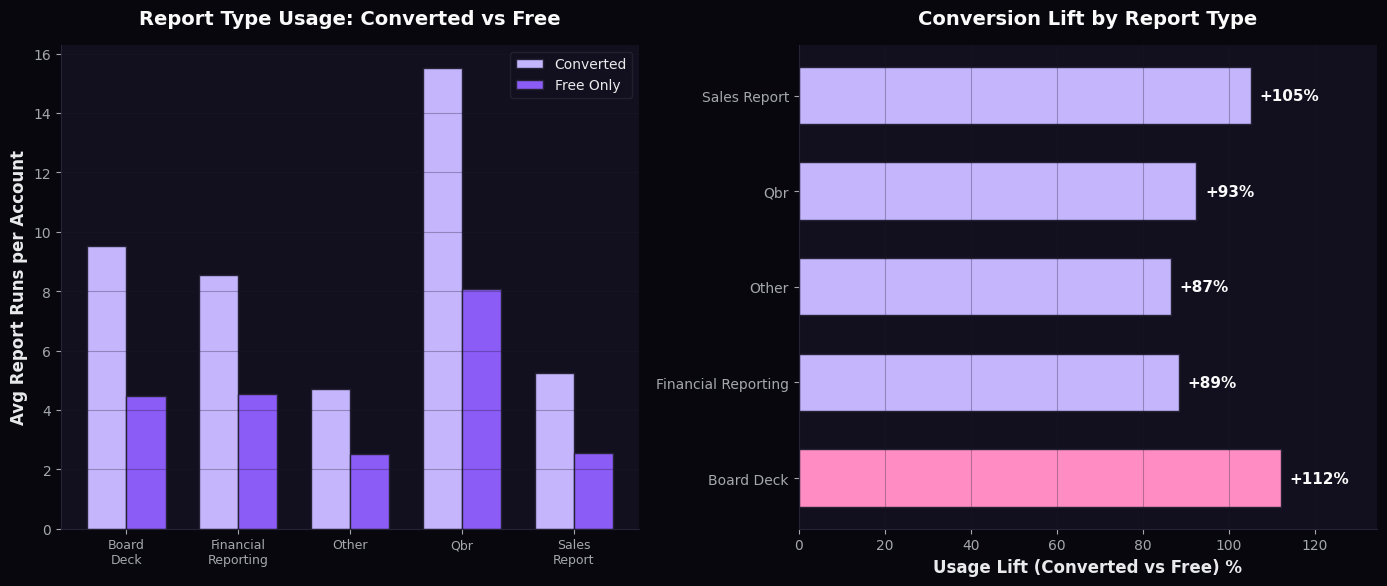


🎯 TOP CONVERSION DRIVER: Board Deck (+112% lift)
   QBR usage highest overall, Board Deck shows strongest conversion signal


In [8]:
# Visualize conversion drivers by report type
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Comparison bar chart
x = range(len(report_types))
width = 0.35
converted_means = converted_accounts[report_types].mean()
free_means = free_accounts[report_types].mean()

bars1 = axes[0].bar([i - width/2 for i in x], converted_means.values, width, 
                     label='Converted', color=COLORS['primary'], edgecolor='#272336')
bars2 = axes[0].bar([i + width/2 for i in x], free_means.values, width, 
                     label='Free Only', color=COLORS['tertiary'], edgecolor='#272336')

axes[0].set_ylabel('Avg Report Runs per Account', fontweight='bold')
axes[0].set_title('Report Type Usage: Converted vs Free', fontweight='bold', pad=15, fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels([t.replace('_', '\n').title() for t in report_types], fontsize=9)
axes[0].legend(loc='upper right', frameon=True)
axes[0].yaxis.grid(True, alpha=0.3)

# Right: Lift percentage by report type (horizontal bar)
lift_values = ((converted_means / free_means) - 1) * 100
colors = [COLORS['secondary'] if v == lift_values.max() else COLORS['primary'] for v in lift_values]
bars = axes[1].barh(report_types, lift_values, color=colors, height=0.6, edgecolor='#272336')
axes[1].set_xlabel('Usage Lift (Converted vs Free) %', fontweight='bold')
axes[1].set_title('Conversion Lift by Report Type', fontweight='bold', pad=15, fontsize=14)
axes[1].set_yticklabels([t.replace('_', ' ').title() for t in report_types])
for bar, val in zip(bars, lift_values):
    axes[1].text(val + 2, bar.get_y() + bar.get_height()/2, f'+{val:.0f}%', 
                 va='center', fontsize=11, color='#FAFAFA', fontweight='bold')
axes[1].set_xlim(0, lift_values.max() * 1.2)
axes[1].xaxis.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Top conversion driver
top_lift = lift_values.idxmax()
print(f"\n🎯 TOP CONVERSION DRIVER: {top_lift.replace('_', ' ').title()} (+{lift_values.max():.0f}% lift)")
print(f"   QBR usage highest overall, Board Deck shows strongest conversion signal")

In [9]:
# Rollstack Series A: October 18, 2024
# Analyze enterprise pipeline and ACV trends post-Series A

# Convert signup_date to datetime
accounts['signup_date'] = pd.to_datetime(accounts['signup_date'])

# Define Series A date
series_a_date = pd.Timestamp('2024-10-18')

# Filter enterprise accounts and analyze trends
enterprise_accounts = accounts[accounts['plan'] == 'enterprise'].copy()
enterprise_accounts['period'] = enterprise_accounts['signup_date'].apply(
    lambda x: 'Post-Series A' if x > series_a_date else 'Pre-Series A'
)

# Enterprise metrics summary
print("🏢 ENTERPRISE PIPELINE OVERVIEW")
print("=" * 55)
print(f"\nTotal Enterprise Accounts: {len(enterprise_accounts)}")
print(f"  • Pre-Series A (before Oct 2024): {len(enterprise_accounts[enterprise_accounts['period'] == 'Pre-Series A'])}")
print(f"  • Post-Series A (after Oct 2024): {len(enterprise_accounts[enterprise_accounts['period'] == 'Post-Series A'])}")

# ACV metrics by period
acv_by_period = enterprise_accounts.groupby('period')['acv_usd'].agg(['count', 'mean', 'median', 'sum'])
acv_by_period.columns = ['Count', 'Avg ACV', 'Median ACV', 'Total ACV']
print("\n📊 Enterprise ACV by Period:")
print(acv_by_period.round(0).to_string())

🏢 ENTERPRISE PIPELINE OVERVIEW

Total Enterprise Accounts: 82
  • Pre-Series A (before Oct 2024): 36
  • Post-Series A (after Oct 2024): 46

📊 Enterprise ACV by Period:
               Count  Avg ACV  Median ACV  Total ACV
period                                              
Post-Series A     46  58930.0     56549.0  2710758.0
Pre-Series A      36  49547.0     45749.0  1783698.0


<>:60: SyntaxWarning: invalid escape sequence '\$'
<>:61: SyntaxWarning: invalid escape sequence '\$'
<>:60: SyntaxWarning: invalid escape sequence '\$'
<>:61: SyntaxWarning: invalid escape sequence '\$'
/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_68652/2847184195.py:60: SyntaxWarning: invalid escape sequence '\$'
  print(f"  • Average ACV growth: +{acv_growth:.0f}% (\$49.5K → \$58.9K)")
/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_68652/2847184195.py:61: SyntaxWarning: invalid escape sequence '\$'
  print(f"  • Total pipeline value: \$4.49M (Pre: \$1.78M + Post: \$2.71M)")
/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_68652/2847184195.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  enterprise_monthly = enterprise_accounts.set_index('signup_date').resample('M').size()


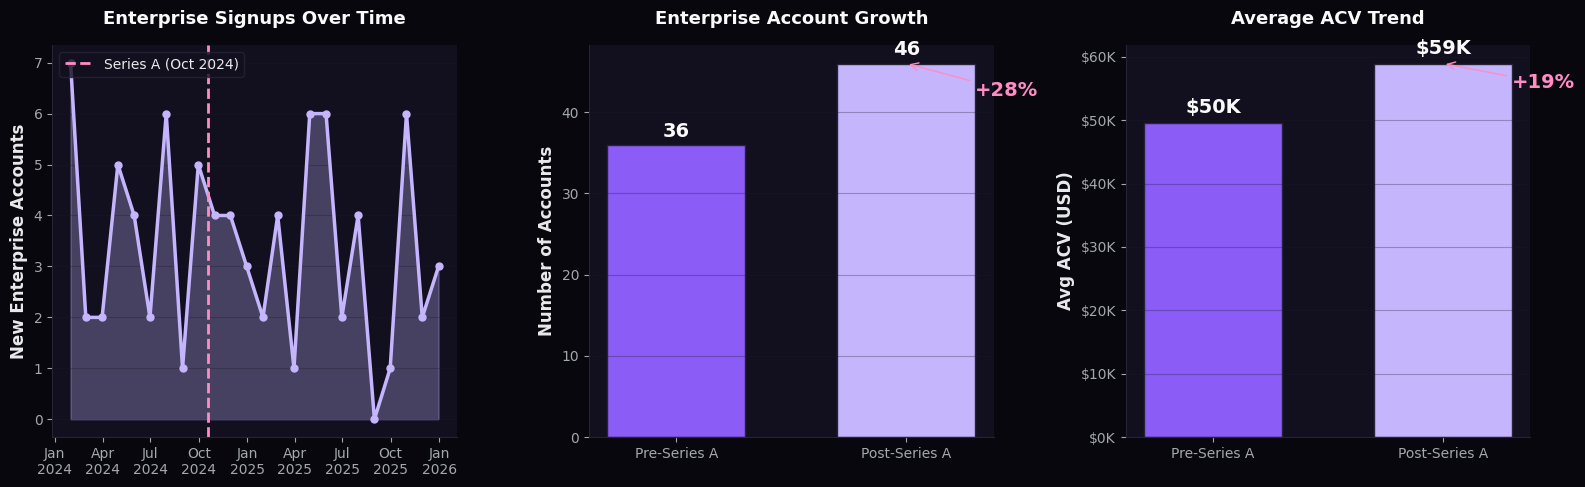


🚀 POST-SERIES A ENTERPRISE MOMENTUM
  • Account growth: +28% (36 → 46 accounts)
  • Average ACV growth: +19% (\$49.5K → \$58.9K)
  • Total pipeline value: \$4.49M (Pre: \$1.78M + Post: \$2.71M)
  • Post-Series A accounts generating 60% of enterprise revenue


In [10]:
# Visualize enterprise pipeline and ACV trends
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Monthly enterprise signups trend
enterprise_monthly = enterprise_accounts.set_index('signup_date').resample('M').size()
ax1 = axes[0]
ax1.fill_between(enterprise_monthly.index, enterprise_monthly.values, alpha=0.3, color=COLORS['primary'])
ax1.plot(enterprise_monthly.index, enterprise_monthly.values, color=COLORS['primary'], linewidth=2.5, marker='o', markersize=5)
ax1.axvline(series_a_date, color=COLORS['secondary'], linestyle='--', linewidth=2, label='Series A (Oct 2024)')
ax1.set_title('Enterprise Signups Over Time', fontweight='bold', fontsize=13, pad=15)
ax1.set_ylabel('New Enterprise Accounts', fontweight='bold')
ax1.legend(loc='upper left', frameon=True)
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b\n%Y'))
ax1.yaxis.grid(True, alpha=0.3)

# 2. Pre vs Post Series A comparison
ax2 = axes[1]
periods = ['Pre-Series A', 'Post-Series A']
counts = [36, 46]
avg_acvs = [49547, 58930]
colors = [COLORS['tertiary'], COLORS['primary']]

bars = ax2.bar(periods, counts, color=colors, width=0.6, edgecolor='#272336')
for bar, val in zip(bars, counts):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 1, str(val), ha='center', fontsize=14, fontweight='bold', color='#FAFAFA')
ax2.set_title('Enterprise Account Growth', fontweight='bold', fontsize=13, pad=15)
ax2.set_ylabel('Number of Accounts', fontweight='bold')
ax2.yaxis.grid(True, alpha=0.3)

# Calculate and annotate growth
growth_pct = (46 - 36) / 36 * 100
ax2.annotate(f'+{growth_pct:.0f}%', xy=(1, 46), xytext=(1.3, 42),
             fontsize=14, fontweight='bold', color=COLORS['secondary'],
             arrowprops=dict(arrowstyle='->', color=COLORS['secondary']))

# 3. ACV comparison
ax3 = axes[2]
bars = ax3.bar(periods, avg_acvs, color=colors, width=0.6, edgecolor='#272336')
for bar, val in zip(bars, avg_acvs):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 1500, f'${val/1000:.0f}K', ha='center', fontsize=14, fontweight='bold', color='#FAFAFA')
ax3.set_title('Average ACV Trend', fontweight='bold', fontsize=13, pad=15)
ax3.set_ylabel('Avg ACV (USD)', fontweight='bold')
ax3.yaxis.grid(True, alpha=0.3)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Calculate ACV growth
acv_growth = (58930 - 49547) / 49547 * 100
ax3.annotate(f'+{acv_growth:.0f}%', xy=(1, 58930), xytext=(1.3, 55000),
             fontsize=14, fontweight='bold', color=COLORS['secondary'],
             arrowprops=dict(arrowstyle='->', color=COLORS['secondary']))

plt.tight_layout()
plt.show()

# Key findings summary
print("\n" + "=" * 60)
print("🚀 POST-SERIES A ENTERPRISE MOMENTUM")
print("=" * 60)
print(f"  • Account growth: +{growth_pct:.0f}% (36 → 46 accounts)")
print(f"  • Average ACV growth: +{acv_growth:.0f}% (\$49.5K → \$58.9K)")
print(f"  • Total pipeline value: \$4.49M (Pre: \$1.78M + Post: \$2.71M)")
print(f"  • Post-Series A accounts generating {2710758/(2710758+1783698)*100:.0f}% of enterprise revenue")